# Pipeline Diagram
Make some figures to show a cartoon of our pipeline diagram

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import astropy.time
import astropy.units as u
from astropy.visualization import ImageNormalize,AsinhStretch,SqrtStretch
from astropy.coordinates import SkyCoord
from sunpy.map import Map,GenericMap
from sunpy.util import MetaDict
import sunpy.coordinates
import sunpy.sun.constants as const
import synthesizAR
import synthesizAR.extrapolate
import yt

%matplotlib inline

First, plot the magnetogram. We'll make a fake one

In [2]:
def make_synthetic_map(xrange, yrange, shape, spots):
    # Setup array
    delta_x = xrange[1] - xrange[0]
    delta_y = yrange[1] - yrange[0]
    dx = delta_x/arr_grid_shape[0]
    dy = delta_y/arr_grid_shape[1]
    data = np.zeros(shape)
    xphysical, yphysical = np.meshgrid(np.arange(shape[0])*dx, np.arange(shape[1])*dy)
    # Add sunspots
    for spot in spots:
        if spot[0].unit is u.percent:
            pos = u.Quantity([spot[0][0].value/100.*delta_x + xrange[0],
                              spot[0][1].value/100.*delta_y + yrange[0]])
        else:
            pos = spot[0]
        if spot[1].unit is u.percent:
            sigma = spot[1].value/100.*delta_x
        else:
            sigma = spot[1]
        a_max   = spot[2].value
        xc_2 = (xphysical - pos[0] + xrange[0]).value**2.0
        yc_2 = (yphysical - pos[1] + yrange[0]).value**2.0
        data += a_max * np.exp( - ( (xc_2 + yc_2) / (2 * sigma.value**2)) )
        
    # Build metadata
    time_now = astropy.time.Time.now()
    observer = sunpy.coordinates.ephemeris.get_earth(time=time_now)
    meta = MetaDict({
        'telescop': 'fake_telescope',
        'instrume': 'fake_mag_imager',
        'detector': 'fake_detector',
        'bunit': 'Gauss',
        'ctype1': 'HPLN-TAN',
        'ctype2': 'HPLT-TAN',
        'hgln_obs': observer.lon.to(u.deg).value,
        'hglt_obs': observer.lat.to(u.deg).value,
        'cunit1': 'arcsec',
        'cunit2': 'arcsec',
        'crpix1': (shape[0] + 1)/2.,
        'crpix2': (shape[1] + 1)/2.,
        'cdelt1': delta_x.to(u.arcsec).value/shape[0],
        'cdelt2': delta_y.to(u.arcsec).value/shape[1],
        'crval1': ((xrange[0] + xrange[1])/2.).value,
        'crval2': ((yrange[0] + yrange[1])/2.).value,
        'dsun_obs': observer.radius.to(u.m).value,
        'dsun_ref': observer.radius.to(u.m).value,
        'rsun_ref': const.radius.to(u.m).value,
        'rsun_obs': ((const.radius/observer.radius).decompose() * u.radian).to(u.arcsec).value,
        't_obs': time_now.iso,
        'date-obs': time_now.iso,
    })
        
    plot_settings = {'cmap': 'hmimag',
                     'norm': matplotlib.colors.Normalize(vmin=-1.5e3, vmax=1.5e3)}
        
    return GenericMap(data, meta, plot_settings=plot_settings)

In [228]:
arr_grid_shape = [ 300, 300]
width_x,width_y = 300 * u.arcsec, 300 * u.arcsec
left_corner_x, left_corner_y = -150 * u.arcsec, -150 * u.arcsec
xrange = u.Quantity((left_corner_x, left_corner_x + width_x))
yrange = u.Quantity((left_corner_y, left_corner_y + width_y))
spots = [
    ( u.Quantity([65,50],u.percent), 3.5*u.percent,  1e3*u.Gauss),
    ( u.Quantity([35,50],u.percent), 3.5*u.percent,  -1e3*u.Gauss),
    #( u.Quantity([35,35],u.percent), 2*u.percent, -1e3*u.Gauss),
    #( u.Quantity([65,65],u.percent), 2*u.percent, -1e3*u.Gauss),
]
magnetogram = make_synthetic_map(xrange,yrange,arr_grid_shape,spots)

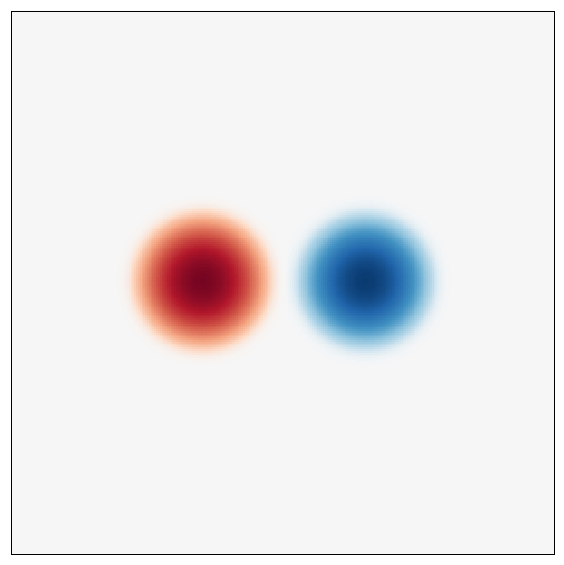

In [231]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=magnetogram)
magnetogram.plot(axes=ax,annotate=False,title=False,cmap='RdBu',
                 norm=matplotlib.colors.SymLogNorm(1,vmin=-1.5e3,vmax=1.5e3))
lon,lat = ax.coords[0],ax.coords[1]
lon.set_ticklabel_visible(False)
lat.set_ticklabel_visible(False)
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
ax.grid(alpha=0)
fig.savefig('../img/magnetogram_diagram.png',format='png',dpi=300,bbox_inches='tight')

Then plot the field extrapolation

In [5]:
shape_z = 100*u.pixel
width_z = 0.3*const.radius

In [6]:
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram,width_z,shape_z)

In [7]:
B_field = extrapolator.extrapolate()

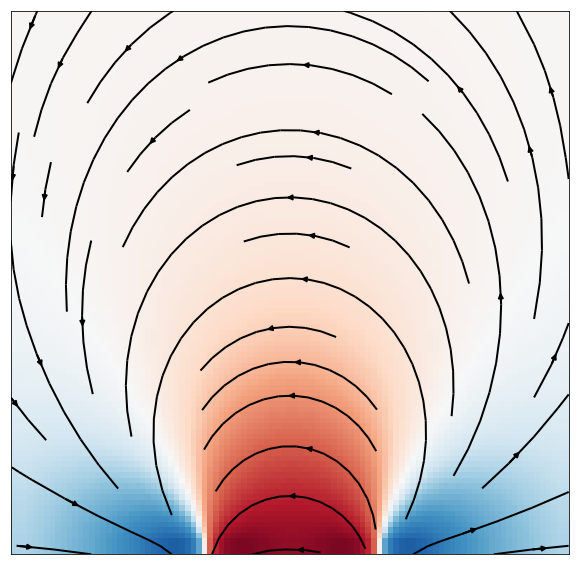

In [232]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax1_grid, ax2_grid = np.meshgrid(np.linspace(-1, 1, B_field.x.shape[1]),
                                 np.linspace(-1, 1, B_field.x.shape[0]))
b_sum = B_field.x[:,:,:].sum(axis=0).value.T
b_stream_1 = B_field.x[:,:,:].sum(axis=0).value.T
b_stream_2 = B_field.z[:,:,:].sum(axis=0).value.T
im = ax.pcolormesh(ax1_grid,ax2_grid,b_sum,
              cmap='RdBu',
              norm=matplotlib.colors.SymLogNorm(500,vmin=-5e3,vmax=5e3)
             )
ax.streamplot(ax1_grid[0, :], ax2_grid[:, 0], b_stream_1, b_stream_2,
              color='k', density=0.5,linewidth=2)
ax.tick_params(axis='both',which='both',
               bottom='off',top='off',left='off',right='off',
               labelbottom='off',labeltop='off',labelleft='off',labelright='off')
#fig.colorbar(im)
fig.savefig('../img/extrapolation_diagram.png',format='png',dpi=300,bbox_inches='tight')

Then plot a few sample fieldlines

In [35]:
fieldlines = extrapolator.trace_fieldlines(B_field,100,loop_length_range=[10,500]*u.Mm,close_threshold=0.05,mask_threshold=0.1,direction=1)

yt : [INFO     ] 2018-05-11 15:45:55,092 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-11 15:45:55,093 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-05-11 15:45:55,093 Parameters: domain_left_edge          = [-1.09358865e+10 -1.09376905e+10  0.00000000e+00]
yt : [INFO     ] 2018-05-11 15:45:55,094 Parameters: domain_right_edge         = [1.09414436e+10 1.09432485e+10 2.08652400e+10]
yt : [INFO     ] 2018-05-11 15:45:55,094 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-05-11 15:45:55,752 AMRKDTree rebuilt, Final Volume: 9.988118e+30
Streamlining: 100%|██████████| 100/100 [00:00<00:00, 361.43it/s]
yt : [INFO     ] 2018-05-11 15:45:56,368 AMRKDTree rebuilt, Final Volume: 9.988118e+30
Streamlining: 100%|██████████| 28/28 [00:00<00:00, 293.53it/s]
yt : [INFO     ] 2018-05-11 15:45:56,732 AMRKDTree rebuilt, Final Volume: 9.988118e+30
Streamlining: 100%|██████████| 10/10 [00:00<00:00, 315.48it/s]


FloatProgress(value=0.0)

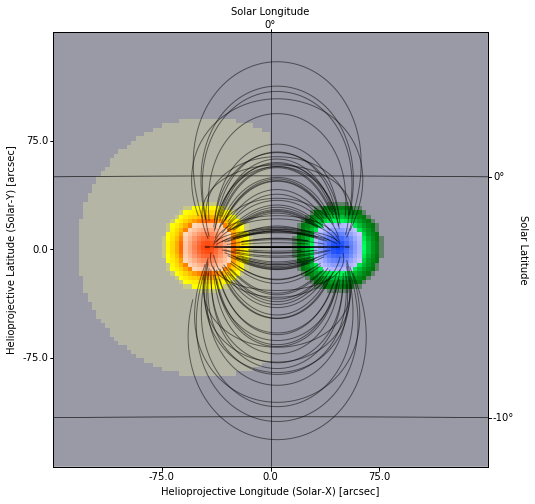

In [36]:
extrapolator.peek(fieldlines,line_frequency=1)

In [37]:
active_region = synthesizAR.Field(magnetogram,fieldlines)

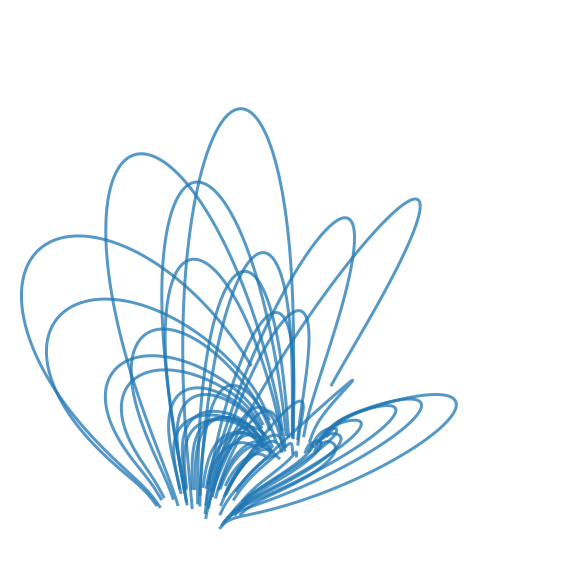

In [233]:
#x_offset = 10*u.Mm
#y_offset = 10*u.Mm
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_axis_off()
for i,l in enumerate(active_region.loops[::2]):
    #s = l.field_aligned_coordinate/l.full_length
    #r = np.sqrt((l.coordinates**2).sum(axis=1))
    #r = r#/r.max()
    ax.plot(l.coordinates[:,1].to(u.Mm),l.coordinates[:,2].to(u.Mm),l.coordinates[:,0].to(u.Mm), color='C0',lw=3,alpha=0.75)
#ax.tick_params(axis='both',which='both',
#               bottom='off',top='off',left='off',right='off',
#               labelbottom='off',labeltop='off',labelleft='off',labelright='off')
ax.set_ylim(-100,20)
ax.set_zlim(700,750)
ax.set_xlim(-100,20)
ax.view_init(35,35)
#ax.set_aspect('auto','datalim')
fig.savefig('../img/fieldlines_diagram.png',format='png',dpi=300,bbox_inches='tight')

Then plot a few sample temperature and density curves

In [190]:
ar_intermediate = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/field_checkpoint/')

In [191]:
loop_num = np.random.randint(0,high=len(ar_intermediate.loops),size=1)[0]
loop = ar_intermediate.loops[loop_num]

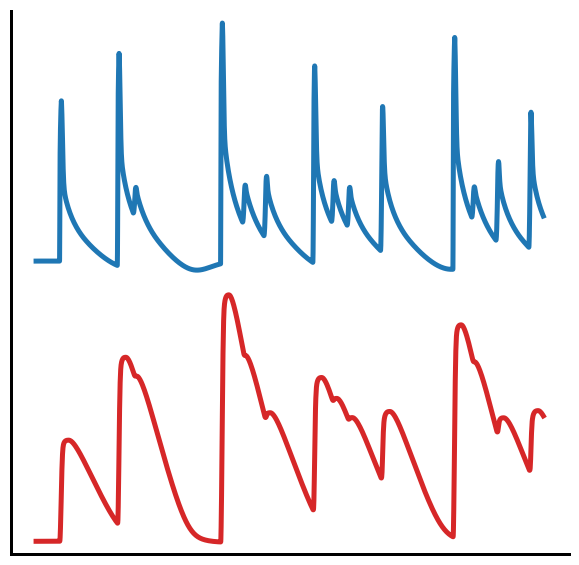

In [234]:
fig,axes = plt.subplots(2,1,figsize=(10,10),sharex=True,)
# Temperature 
axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',lw=5,)
axes[0].tick_params(axis='both',which='both',
               bottom='off',top='off',left='off',right='off',
               labelbottom='off',labeltop='off',labelleft='off',labelright='off')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_linewidth(3)
# Density
axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C3',lw=5)
axes[1].tick_params(axis='both',which='both',
               bottom='off',top='off',left='off',right='off',
               labelbottom='off',labeltop='off',labelleft='off',labelright='off')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_linewidth(3)
axes[1].spines['bottom'].set_linewidth(3)
plt.subplots_adjust(hspace=0)
fig.savefig('../img/profiles_diagram.png',format='png',dpi=300,bbox_inches='tight')

Then plot a synthesized image

In [224]:
m = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/nei/SDO_AIA/171/map_t001500.fits')
m = m.submap(
    SkyCoord(-370*u.arcsec,-315*u.arcsec,frame=m.coordinate_frame),
    SkyCoord(-220*u.arcsec,-165*u.arcsec,frame=m.coordinate_frame),
)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


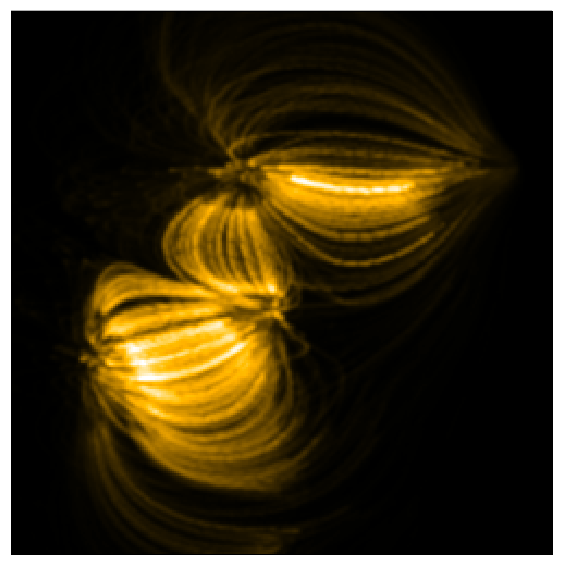

In [235]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=m)
m.plot(axes=ax,annotate=False,title=False,
       norm=ImageNormalize(vmin=0,vmax=1.5e3,stretch=AsinhStretch(0.1))
      )
ax.grid(alpha=0)
lon,lat = ax.coords[0],ax.coords[1]
lon.set_ticklabel_visible(False)
lat.set_ticklabel_visible(False)
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
fig.savefig('../img/aia_diagram.png',format='png',dpi=300,bbox_inches='tight')